In [1]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm

In [2]:
 # Check if CUDA is available
print(torch.cuda.is_available())

True


In [3]:
# Print PyTorch version
torch.__version__

'2.2.1+cu121'

In [4]:
seed = 9072

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [5]:
# Load IMDb dataset
train_data, test_data = datasets.load_dataset("imdb", split=["train", "test"])

In [6]:
# Get tokenizer
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

In [7]:
def tokenize_example(example, tokenizer, max_length):
    tokens = tokenizer(example["text"])[:max_length]
    length = len(tokens)
    return {"tokens": tokens, "length": length}

In [8]:
max_length = 256

train_data = train_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
test_data = test_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

In [9]:
# Split train data into train and validation sets
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

In [10]:
len(train_data), len(valid_data), len(test_data)

(18750, 6250, 25000)

In [11]:
min_freq = 5
special_tokens = ["<unk>", "<pad>"]

vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [12]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

In [13]:
vocab.set_default_index(unk_index)

In [14]:
# Numericalize example with vocabulary
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}

In [15]:
train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

In [16]:
train_data = train_data.with_format(type="torch", columns=["ids", "label", "length"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label", "length"])
test_data = test_data.with_format(type="torch", columns=["ids", "label", "length"])

In [17]:
train_data[0]

{'label': tensor(0),
 'length': tensor(256),
 'ids': tensor([  500,     2,  7768,    27,     2,   273,  1026,     7,     2,   308,
            12,  4828,     4,    14,    23,    17,     5,  1333,     3,   413,
             4,    11,    10,   242,    62,   793,    84,    94,   328,   117,
             7,     2,   785,    21,  4915,     2,  8677,     4,  3205,     6,
          4065,     7,     2,     0,     4,    22,   449,    34,   278,   259,
            44,    11,   517,    15,     9,    16,    37,    46,    10,     8,
            14,    18,     3,    46,    10,    69,   114,     6,     2,   428,
            10,  9679,     3,    11,     9,    16,    29,    15,     5,    56,
           328,    23,   738,     8,    31,     5,  1036,   157,   172,   706,
           904,     3,    34,     7,     2,   118,   188,   328,  1430,   117,
             4,  4361,   772,     9,  4439,   306,     4,    50,    58,   125,
           220,     3,    22,    11,     0,    20, 19795,   428,     6,  1944,


In [18]:
# Define collate function for batching data
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_length = [i["length"] for i in batch]
        batch_length = torch.stack(batch_length)
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "length": batch_length, "label": batch_label}
        return batch

    return collate_fn

In [19]:
# Get data loaders for train, validation, and test sets
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [20]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [21]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        n_layers,
        bidirectional,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            n_layers,
            bidirectional=bidirectional,
            dropout=dropout_rate,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids, length):
        # ids = [batch size, seq len]
        # length = [batch size]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        # output = [batch size, seq len, hidden dim * n directions]
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
            # hidden = [batch size, hidden dim * 2]
        else:
            hidden = self.dropout(hidden[-1])
            # hidden = [batch size, hidden dim]
        prediction = self.fc(hidden)
        # prediction = [batch size, output dim]
        return prediction

In [22]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = len(train_data.unique("label"))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_index,
)

In [23]:
# Function to count the number of trainable parameters in a model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 10,074,602 trainable parameters


In [24]:
# Initialize model weights
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

In [25]:
model.apply(initialize_weights)

LSTM(
  (embedding): Embedding(21546, 300, padding_idx=1)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=600, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [26]:
# Load pretrained GloVe word vectors
vectors = torchtext.vocab.GloVe()

In [27]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

In [28]:
# Set up model, optimizer, criterion, and device
model.embedding.weight.data = pretrained_embedding

In [29]:
lr = 5e-4

optimizer = optim.Adam(model.parameters(), lr=lr)

In [30]:
criterion = nn.CrossEntropyLoss()

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [32]:
model = model.to(device)
criterion = criterion.to(device)

In [33]:
# Training function
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    epoch_precisions = []
    epoch_recalls = []
    epoch_f1s = []

    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        length = batch["length"]
        label = batch["label"].to(device)
        prediction = model(ids, length)
        
        loss = criterion(prediction, label)
        accuracy, precision, recall, f1 = get_metrics(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy)
        epoch_precisions.append(precision)
        epoch_recalls.append(recall)
        epoch_f1s.append(f1)
    return np.mean(epoch_losses), np.mean(epoch_accs), np.mean(epoch_precisions), np.mean(epoch_recalls), np.mean(epoch_f1s)

In [34]:
# Evaluation function
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    epoch_precisions = []
    epoch_recalls = []
    epoch_f1s = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            label = batch["label"].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy, precision, recall, f1 = get_metrics(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy)
            epoch_precisions.append(precision)
            epoch_recalls.append(recall)
            epoch_f1s.append(f1)
    return np.mean(epoch_losses), np.mean(epoch_accs), np.mean(epoch_precisions), np.mean(epoch_recalls), np.mean(epoch_f1s)

In [35]:
# Function to calculate accuracy, precision, recall, and F1 score
def get_metrics(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum().item()
    accuracy = correct_predictions / batch_size

    true_positive = (predicted_classes & label).sum().item()
    predicted_positive = predicted_classes.sum().item()
    actual_positive = label.sum().item()

    precision = true_positive / predicted_positive if predicted_positive > 0 else 0
    recall = true_positive / actual_positive if actual_positive > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1

In [36]:
# Training loop
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc, train_precision, train_recall, train_f1 = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc, valid_precision, valid_recall, valid_f1 = evaluate(
        valid_data_loader, model, criterion, device
    )
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["train_precisions"].append(train_precision)
    metrics["train_recalls"].append(train_recall)
    metrics["train_f1s"].append(train_f1)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    metrics["valid_precisions"].append(valid_precision)
    metrics["valid_recalls"].append(valid_recall)
    metrics["valid_f1s"].append(valid_f1)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "rnn.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}, train_precision: {train_precision:.3f}, train_recall: {train_recall:.3f}, train_f1: {train_f1:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}, valid_precision: {valid_precision:.3f}, valid_recall: {valid_recall:.3f}, valid_f1: {valid_f1:.3f}")

evaluating...: 100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


epoch: 0
train_loss: 0.621, train_acc: 0.640, train_precision: 0.662, train_recall: 0.628, train_f1: 0.617
valid_loss: 0.473, valid_acc: 0.770, valid_precision: 0.828, valid_recall: 0.677, valid_f1: 0.744


evaluating...: 100%|██████████| 13/13 [00:01<00:00,  8.25it/s]


epoch: 1
train_loss: 0.478, train_acc: 0.774, train_precision: 0.792, train_recall: 0.764, train_f1: 0.768
valid_loss: 0.419, valid_acc: 0.809, valid_precision: 0.872, valid_recall: 0.720, valid_f1: 0.789


evaluating...: 100%|██████████| 13/13 [00:01<00:00,  9.80it/s]


epoch: 2
train_loss: 0.374, train_acc: 0.837, train_precision: 0.843, train_recall: 0.835, train_f1: 0.836
valid_loss: 0.347, valid_acc: 0.855, valid_precision: 0.827, valid_recall: 0.894, valid_f1: 0.859


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 10.09it/s]


epoch: 3
train_loss: 0.369, train_acc: 0.838, train_precision: 0.845, train_recall: 0.842, train_f1: 0.838
valid_loss: 0.371, valid_acc: 0.852, valid_precision: 0.823, valid_recall: 0.895, valid_f1: 0.857


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 10.08it/s]


epoch: 4
train_loss: 0.330, train_acc: 0.864, train_precision: 0.867, train_recall: 0.864, train_f1: 0.863
valid_loss: 0.353, valid_acc: 0.866, valid_precision: 0.892, valid_recall: 0.830, valid_f1: 0.860


evaluating...: 100%|██████████| 13/13 [00:01<00:00,  9.99it/s]


epoch: 5
train_loss: 0.282, train_acc: 0.886, train_precision: 0.885, train_recall: 0.890, train_f1: 0.886
valid_loss: 0.307, valid_acc: 0.877, valid_precision: 0.851, valid_recall: 0.913, valid_f1: 0.880


evaluating...: 100%|██████████| 13/13 [00:01<00:00,  9.54it/s]


epoch: 6
train_loss: 0.260, train_acc: 0.897, train_precision: 0.896, train_recall: 0.901, train_f1: 0.898
valid_loss: 0.298, valid_acc: 0.878, valid_precision: 0.878, valid_recall: 0.876, valid_f1: 0.876


evaluating...: 100%|██████████| 13/13 [00:01<00:00,  9.99it/s]


epoch: 7
train_loss: 0.243, train_acc: 0.905, train_precision: 0.906, train_recall: 0.905, train_f1: 0.904
valid_loss: 0.296, valid_acc: 0.878, valid_precision: 0.850, valid_recall: 0.915, valid_f1: 0.881


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 10.00it/s]


epoch: 8
train_loss: 0.223, train_acc: 0.912, train_precision: 0.913, train_recall: 0.914, train_f1: 0.912
valid_loss: 0.315, valid_acc: 0.881, valid_precision: 0.917, valid_recall: 0.835, valid_f1: 0.874


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 10.10it/s]

epoch: 9
train_loss: 0.197, train_acc: 0.924, train_precision: 0.927, train_recall: 0.923, train_f1: 0.924
valid_loss: 0.301, valid_acc: 0.888, valid_precision: 0.875, valid_recall: 0.904, valid_f1: 0.889


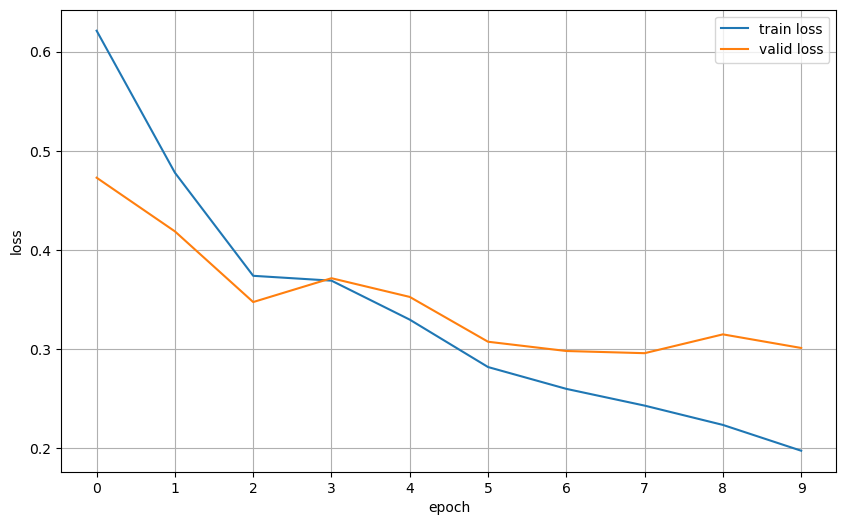

In [37]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()
plt.savefig("RNN_loss_curve.png")

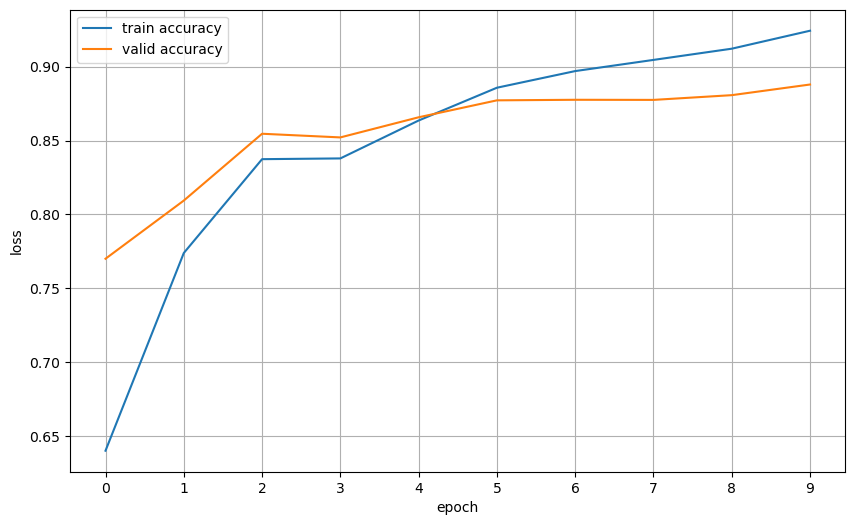

In [38]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()
plt.savefig("RNN_accuracy.png")

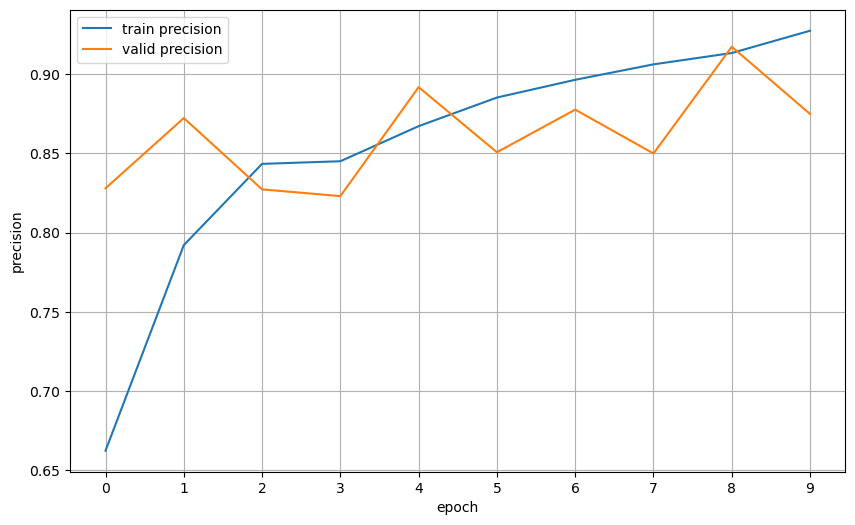

In [39]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics['train_precisions'], label="train precision")
ax.plot(metrics['valid_precisions'], label="valid precision")
ax.set_xlabel("epoch")
ax.set_ylabel("precision")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()
plt.savefig("RNN_precision.png")

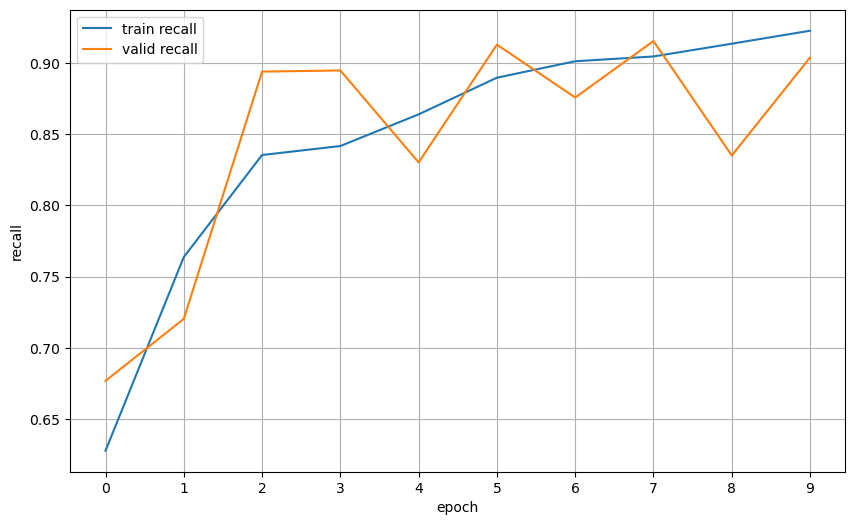

In [40]:
# Plotting Training Metrics
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics['train_recalls'], label="train recall")
ax.plot(metrics['valid_recalls'], label="valid recall")
ax.set_xlabel("epoch")
ax.set_ylabel("recall")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()
plt.savefig("RNN_recall.png")

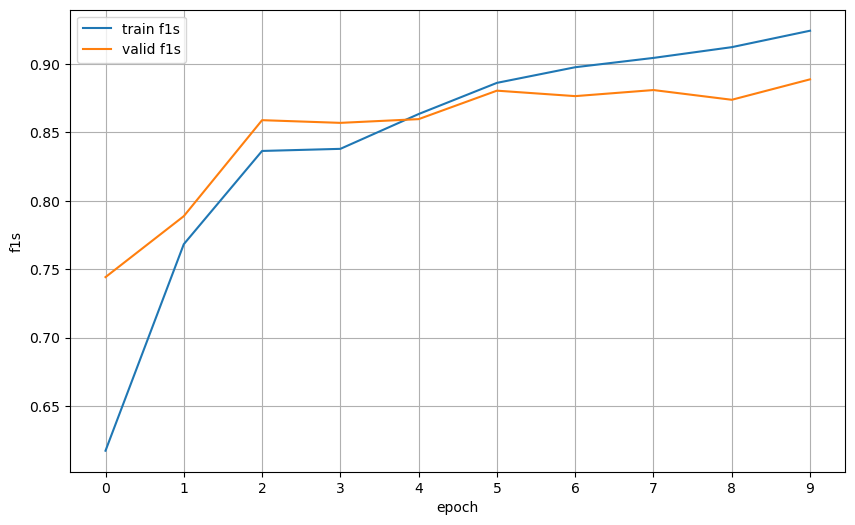

In [41]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics['train_f1s'], label="train f1s")
ax.plot(metrics['valid_f1s'], label="valid f1s")
ax.set_xlabel("epoch")
ax.set_ylabel("f1s")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()
plt.savefig("RNN_f1score.png")

In [42]:
# Loading Saved Model and Testing
model.load_state_dict(torch.load("rnn.pt"))

test_metrics = evaluate(test_data_loader, model, criterion, device)
test_loss = test_metrics[0] #loss
test_acc = test_metrics[1] #accuracy
test_precision = test_metrics[2] #precision
test_recall = test_metrics[3] #recall
test_f1 = test_metrics[4] #f1score

evaluating...: 100%|██████████| 49/49 [00:05<00:00,  9.04it/s]


In [43]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")
print(f"test_precision: {test_precision:.3f}, test_recall: {test_recall:.3f}, test_f1: {test_f1:.3f}")

test_loss: 0.301, test_acc: 0.871
test_precision: 0.508, test_recall: 0.459, test_f1: 0.482


In [44]:
# Sentiment Prediction Function
def predict_sentiment(text, model, tokenizer, vocab, device):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [45]:
# Case study（Sentiment Prediction Examples）
text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.8946091532707214)

In [46]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.9197730422019958)

In [47]:

text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.5956609845161438)

In [48]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.5821391940116882)

In [49]:
text = '''When thinking of boxing films, there is already a series of predecessors: "Rocky" (1976), "Million Dollar Baby" (2004), "Unbeatable" (2013), and so on. The movie "Hot and Heavy" adapted from Masaharu Take's "100 Yen Love" (2014, starring Sakura Ando) also tells a story of an underdog's rise and struggle, showcasing the passion for life encapsulated in the phrase "You Only Live Once."

The film addresses social phenomena in China such as "lying flat" (tang ping), otaku culture, the "boomerang generation" (those who depend on their parents), and the media's fabrication of reality, with the story set against the backdrop of card gambling. Although the movie was shot in the Guangdong region, it lacks a distinct Cantonese flavor and sense of place, resembling a typical second or third-tier city in China aimed at a nationwide audience. Surprisingly, Lee Kwok Lun, known for his role as Jiumozhi in the beloved TV drama "Demi-Gods and Semi-Devils," represents a vestige of value from Hong Kong's film and television culture.

The focus of the film is on the actress Jia Ling's remarkable physical transformation, where she gained approximately 50 pounds and then lost around 130 pounds. The process is deeply moving and demonstrates that individuals who have dreams and persist in pursuing them are the most beautiful. On another level, the film also shows Jia Ling's discipline over her body, reflecting both collective political elements and the pursuit of personal breakthroughs.
'''

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.9708129167556763)

In [50]:
text = '''WA film adaptation of a true story about Britain's "Shtetl's List". When Prime Minister Chamberlain's appeasement policy fuels Hitler's totalitarian ambitions, the Czech Republic is in dire straits. Nicholas Winton sees the situation deteriorating and, out of compassion, goes all out to save the Jewish children. The rabbi tells Winton not to leave things unfinished, and Winton's diligence in doing a good deed deserves to be remembered for generations to come, but at the most important moment, things don't turn out well, and there is no way back, leaving Winton with a lifetime of guilt. The unique experience of an individual can be a heavy lesson in history, worthy of rethinking by future generations.

The Miracle Train hovers between the extraordinary period of 1938 and the stable period of 1988, between memory and the present. Anthony Hopkins' excellent performance is certainly the core of the film, and it is also rare to see James Hawes, who is making his feature film debut, making his debut with a rather skilled and restrained approach.
'''

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.9768478870391846)

In [51]:
text = '''One of the most puzzling aspects of "Goldfinger" is the lack of insight and personal perspective from the director regarding the sensational "Jia Ning case" and its mastermind. The character Cheng Yiyuan, portrayed by Tony Leung Chiu-Wai, becomes arrogant and driven by greed after entering the rapidly growing financial market, resorting to increasingly ruthless methods. The film employs visual and stylistic techniques to emphasize the exaggerated sense of decadence and corruption.

However, beneath the surface dazzle, it merely reinforces the conventional impression of powerful and wealthy "villains." Several scenes in the film's composition clearly bear the influence of both Martin Scorsese's earlier and recent works, which is unnecessary. Chapman To's mocking reference to Joe Pesci's "funny how" sequence in "Goodfellas" (1990) invites the audience to make comparisons but comes off as awkward.

I have read some interviews with Felix Chong and Tony Leung Chiu-Wai, where Chong discusses his childhood memories of observing how the Jia Ning case affected people in the community, and Leung casually mentions that the Jia Ning chairman was probably just an ordinary businessman initially driven by a desire to make money. These aspects are more thought-provoking than what "Goldfinger" presents. The current script focuses on the confrontation between Cheng Yiyuan and the anti-corruption agency, skillfully maintaining a high-intensity dramatic tension. However, it falls short in exploring the significant aspects of real-life events. It treats past history merely as a blueprint for genre films, stopping at technical craftsmanship and thrilling plot development. This falls short of what can be considered a truly exemplary Hong Kong story.
'''

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.9866098761558533)